In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import statsmodels.api as sm
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight")
%pylab inline

/Users/rspd/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


Populating the interactive namespace from numpy and matplotlib


### Download data from DOB Sheds Map
Source: https://www1.nyc.gov/assets/buildings/html/sidewalk-shed-map.html

In [2]:
dobmap = pd.read_csv('data/cartodb-query.csv')
print(dobmap.shape)
print(dobmap.columns)
dobmap.head()

(8233, 26)
Index(['the_geom', 'bin_number', 'the_geom_webmercator', 'job_number',
       'borough_name', 'count_permits', 'first_permit_date', 'current_date',
       'age', 'permit_expiration_date', 'sidewalk_shed_linear_feet',
       'construction_material', 'current_job_status', 'cartodb_id',
       'community_board', 'latitude_point', 'longitude_point', 'house_number',
       'street_name', 'borough_digit', 'block', 'lot',
       'applicant_business_name', 'procert', 'source', 'activity'],
      dtype='object')


,the_geom,bin_number,the_geom_webmercator,job_number,borough_name,count_permits,first_permit_date,current_date,age,permit_expiration_date,...,longitude_point,house_number,street_name,borough_digit,block,lot,applicant_business_name,procert,source,activity
0,NaN,4007109,NaN,440245192(BIS),QUEENS,0.0,8/19/2015 12:00,6/21/2018,1036,8/11/2018,...,-73.926628,31-35,CRESCENT STREET,4,579,36.0,SCAFFOLD DISTRIBUTORS OF,1,BIS,Local Law 11
1,NaN,2083678,NaN,240114149(BIS),BRONX,0.0,9/21/2015 12:00,6/21/2018,1003,10/17/2018,...,-73.906502,3409,IRWIN AVENUE,2,5759,573.0,"METRO CONTRACTING NY, INC",1,BIS,Local Law 11
2,NaN,3215591,NaN,340299803(BIS),BROOKLYN,0.0,10/17/2015 12:00,6/21/2018,977,9/26/2018,...,-73.927513,1258,EAST 51 STREET,3,7776,26.0,ROCK GROUP NY CORP,1,BIS,Local Law 11
3,NaN,2092678,NaN,240124307(BIS),BRONX,0.0,11/24/2015 12:00,6/21/2018,939,6/12/2019,...,-73.846298,2245,RANDALL AVENUE,2,3573,1.0,ABAX INC,1,BIS,Local Law 11
4,NaN,2008130,NaN,240145794(BIS),BRONX,0.0,6/17/2016 12:00,6/21/2018,733,6/4/2019,...,-73.914230,1525,WALTON AVENUE,2,2845,70.0,ADVANCED CONSTRUCTION EQU,1,BIS,Local Law 11


### Adding a full BBL variable (Currently has it split between three columns)

**From PLUTO data dictionary:**
This field consists of the borough code followed by the tax block followed by the tax lot. The borough code is one numeric digit. The tax block is one to five numeric digits, preceded with leading zeros when the block is less than five digits. The tax lot is one to four digits and is preceded with leading zeros when the lot is less than four digits.
Examples:
Manhattan Borough Code 1, Tax Block 16, Tax Lot 100 would be stored as 1000160100.
Brooklyn Borough Code 3, Tax Block 15828, Tax Lot 7501 would be stored as 5158287501.

In [3]:
dobmap['block'] = '0000' + dobmap['block'].astype(str)
dobmap['block'] = dobmap['block'].str[-5:]
dobmap['lot'] = dobmap['lot'].fillna(0).astype(int)
dobmap['lot'] = '0000' + dobmap['lot'].astype(str)
dobmap['lot'] = dobmap['lot'].str[-4:]
dobmap['bbl'] = dobmap['borough_digit'].astype(str) + dobmap['block'].astype(str) + dobmap['lot'].astype(str)
dobmap['bbl'][::800]

0       4005790036
800     4094120051
1600    3053360082
2400    1012700001
3200    4003750001
4000    1019890050
4800    1001690010
5600    1020350001
6400    4034550041
7200    3072470264
8000    4063710010
Name: bbl, dtype: object

### Adding a column with a 1 to be able to groupby later on

In [4]:
dobmap['num_sheds'] = 1

### How many sheds are for Local Law 11 (FISP)?

In [5]:
print(dobmap['activity'].value_counts())
print("Percent of Sheds that Are Local Law 11:", ((dobmap['activity'] == 'Local Law 11').sum() / 
      ((dobmap['activity'] == 'Construction or Maintenance').sum() + (dobmap['activity'] == 'Local Law 11').sum()) * 100).round(2))

Construction or Maintenance    5745
Local Law 11                   2488
Name: activity, dtype: int64
Percent of Sheds that Are Local Law 11: 30.22


### Filtering dataset to just Local Law 11 records

In [6]:
dobmap_11 = dobmap[dobmap['activity'] == 'Local Law 11']

### How old are the sheds? 

In [7]:
print("The average shed has been up for", round(dobmap_11['age'].mean()), "days.")
print("The median shed has been up for", round(dobmap_11['age'].median()), "days.")
print("The youngest sheds have been up for", round(dobmap_11['age'].min()), "days.")
print("The oldest sheds have been up for", round(dobmap_11['age'].max()), "days.")
print((dobmap_11['age']>365).sum(), "sheds have been up for more than 1 year.")
print((dobmap_11['age']>365*2).sum(), "sheds have been up for more than 2 years.")
print((dobmap_11['age']>365*3).sum(), "sheds have been up for more than 3 years.")
print((dobmap_11['age']>365*4).sum(), "sheds have been up for more than 4 years.")
print((dobmap_11['age']>365*5).sum(), "sheds have been up for more than 5 years.")
print((dobmap_11['age']>365*6).sum(), "sheds have been up for more than 6 years.")
print((dobmap_11['age']>365*7).sum(), "sheds have been up for more than 7 years.")
print((dobmap_11['age']>365*8).sum(), "sheds have been up for more than 8 years.")

The average shed has been up for 428 days.
The median shed has been up for 312 days.
The youngest sheds have been up for 0 days.
The oldest sheds have been up for 4437 days.
1068 sheds have been up for more than 1 year.
444 sheds have been up for more than 2 years.
167 sheds have been up for more than 3 years.
99 sheds have been up for more than 4 years.
50 sheds have been up for more than 5 years.
24 sheds have been up for more than 6 years.
13 sheds have been up for more than 7 years.
8 sheds have been up for more than 8 years.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x10ff0b550>]],
      dtype=object)

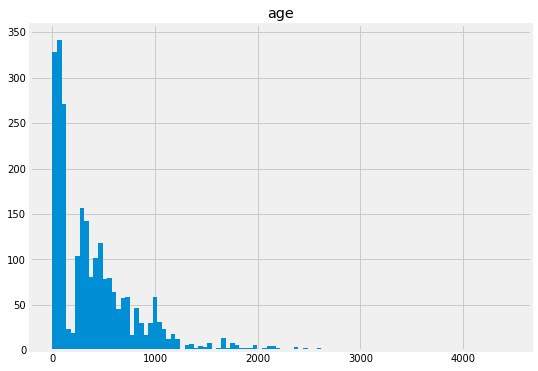

In [8]:
dobmap_11.hist('age', bins=100, figsize=(8,6))

### How big are the sheds? 

In [9]:
print("The average shed length is", round(dobmap_11['sidewalk_shed_linear_feet'].mean()), "feet.")
print("The median shed length is", round(dobmap_11['sidewalk_shed_linear_feet'].median()), "feet.")
print("The minimum shed length is", round(dobmap_11['sidewalk_shed_linear_feet'].min()), "feet.")
print("The maximum shed length is", round(dobmap_11['sidewalk_shed_linear_feet'].max()), "feet (equal to", 
      round(dobmap_11['sidewalk_shed_linear_feet'].max()/5280, 2), 'miles).')

The average shed length is 295 feet.
The median shed length is 210 feet.
The minimum shed length is 8 feet.
The maximum shed length is 2924 feet (equal to 0.55 miles).


#### Where are the 10 biggest sheds and how old are they? 

In [10]:
dobmap_11.sort_values('sidewalk_shed_linear_feet', ascending=False).head(10)[['sidewalk_shed_linear_feet', 'borough_name', 'age']]

,sidewalk_shed_linear_feet,borough_name,age
946,2924,BRONX,831
8018,2170,QUEENS,2
1154,2100,QUEENS,729
4827,2000,MANHATTAN,187
807,1997,BRONX,912
2003,1983,BROOKLYN,510
4292,1948,BROOKLYN,273
4291,1948,BROOKLYN,273
420,1843,BRONX,1163
319,1837,MANHATTAN,1322


**Many of the biggest sheds have been up for more than 1 year**

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x116a46828>]],
      dtype=object)

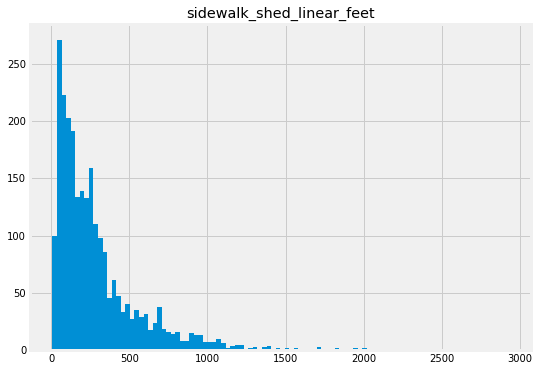

In [11]:
dobmap_11.hist('sidewalk_shed_linear_feet', bins=100, figsize=(8,6))

### Is there any correlation between shed length and shed age? 

In [12]:
y = dobmap_11['age']
X = dobmap_11['sidewalk_shed_linear_feet']
model = sm.OLS(y, X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    age   R-squared:                       0.254
Model:                            OLS   Adj. R-squared:                  0.254
Method:                 Least Squares   F-statistic:                     848.9
Date:                Fri, 22 Jun 2018   Prob (F-statistic):          8.14e-161
Time:                        13:05:25   Log-Likelihood:                -19218.
No. Observations:                2488   AIC:                         3.844e+04
Df Residuals:                    2487   BIC:                         3.844e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
sidewalk_shed_linear_feet     0.7712      0.026     29.136      0.000       0.719       0.823
==============================================================================
Omnibus:                      939.377   Durbin-Watson:                   0.298
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             6017.119
Skew:                           1.645   Prob(JB):                         0.00
Kurtosis:                       9.872   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**The R2 between age and length is 0.254**

### Who are the most frequent applicants?

In [13]:
dobmap_11['applicant_business_name'].value_counts().head(10)

AE DESIGN SOLUTION INC     277
EVEREST SCAFFOLDING INC    168
JOEL PHAGOO P.E. PLLC      124
VICTOR SUBEN P.E           108
SPRING SCAFFOLDING LLC     104
ROCK GROUP NY CORP          99
SKYWORX CONTRACTING INC     83
PHOENIX SUTTON STR INC      59
ROMA SCAFFOLDING INC        53
BRIAN T. O'CONNOR           51
Name: applicant_business_name, dtype: int64

**One company stands out as having far more than any other company: AE Design Solutions**

### Does shed age differ by the applicant name? 

#### Companies with the oldest median shed age

In [14]:
gby_dct = {'age': ['median'], 'num_sheds': ['sum']}
gby = dobmap_11.groupby(["applicant_business_name"]).agg(gby_dct).reset_index()
gby.columns = gby.columns.droplevel(1)
gby.columns = ['applicant_business_name', 'age_median', 'num_sheds_sum']
gby.sort_values('age_median', ascending=False).head(10)

,applicant_business_name,age_median,num_sheds_sum
96,PICCO CONSTRUCTION LLC,3745.0,1
72,LO SARDO GENERAL CONTRACT,3604.0,1
122,SASCO CONSTRUCTION ENTER,2371.0,3
145,TRES CONSTRUCTION LLC,2120.0,1
107,RASHEL CONSTRUCTION CORP,1538.0,2
119,S&E BRIDGE & SCAFFOLD LLC,1467.0,10
105,PRECISION HOIST & SCAFFO*,1309.0,3
78,MINELLI CONSTRUCTION CO,1290.0,1
5,ABDUL KARIM,1232.0,1
55,HERBERT ROSE INC,1108.0,1


#### Companies with the most number of sheds

In [15]:
gby.sort_values('num_sheds_sum', ascending=False).head(10)

,applicant_business_name,age_median,num_sheds_sum
8,AE DESIGN SOLUTION INC,69.0,277
45,EVEREST SCAFFOLDING INC,500.5,168
64,JOEL PHAGOO P.E. PLLC,59.5,124
156,VICTOR SUBEN P.E,62.0,108
134,SPRING SCAFFOLDING LLC,481.0,104
114,ROCK GROUP NY CORP,548.0,99
132,SKYWORX CONTRACTING INC,617.0,83
95,PHOENIX SUTTON STR INC,468.0,59
116,ROMA SCAFFOLDING INC,715.0,53
24,BRIAN T. O'CONNOR,64.0,51


**A number of companies with a lot of sheds have pretty long median shed ages as well: Everst, Spring, Rock Group, Skyworx, Phoenix, Roma.**

In [16]:
# dobmap_11.groupby('applicant_business_name').median()[['age']].sort_values('age', ascending=False).head(20)

In [17]:
# dobmap_11.groupby('applicant_business_name').median()[['age', 'num_sheds']].sort_values('num_sheds', ascending=False).head(20)

### How many sheds per borough? 

In [18]:
dobmap_11['borough_name'].value_counts()

MANHATTAN        1547
BRONX             342
BROOKLYN          321
QUEENS            268
STATEN ISLAND      10
Name: borough_name, dtype: int64

**Manhattan far and away has the most sheds**

In [ ]:
plt.hist(dobmap_11['borough_name'])

## Facilities
### Do public buildings have sheds? 

Source: https://data.cityofnewyork.us/City-Government/Facilities-Database-Shapefile/2fpa-bnsx

In [ ]:
facilities = pd.read_csv("data/facilities.csv")
print(facilities.shape)
facilities.head(3)

In [ ]:
#Changing datatype so they merge
dobmap_11['bin_number'] = dobmap_11['bin_number'].astype(str)
shed_pub = dobmap_11.merge(facilities, left_on='bin_number', right_on='bin')
print(dobmap_11.shape)
print(shed_pub.shape)
shed_pub.head()

In [ ]:
shed_pub = shed_pub[['bin_number', 'first_permit_date', 'current_date',
       'age', 'permit_expiration_date', 'sidewalk_shed_linear_feet', 'current_job_status',
       'community_board', 'latitude_point', 'longitude_point', 'house_number',
       'street_name', 'borough_digit', 'block', 'lot',
       'applicant_business_name', 'activity', 'num_sheds', 'facname', 'facsubgrp', 'factype', 'overagency', 'overabbrev', 'optype']]
shed_pub.head(3)

In [ ]:
shed_pub['optype'].value_counts()

### Filtering to just public types

In [ ]:
shed_pub = shed_pub[shed_pub['optype'] == 'Public']
print(shed_pub.shape)

**There are 368 public buildings with sheds up because of Local Law 11**

In [ ]:
shed_pub['facsubgrp'].value_counts().head(10)

**What agency have the most sheds up?**

In [ ]:
shed_pub['overagency'].value_counts().head(10)

**NYCHA has the most sheds, followed by Office of Mental Health, and DOE**

In [ ]:
print("The average public shed has been up for", round(shed_pub['age'].mean()), "days.")
print("The median public shed has been up for", round(shed_pub['age'].median()), "days.")
print("The youngest public shed has been up for", round(shed_pub['age'].min()), "days.")
print("The oldest public shed have been up for", round(shed_pub['age'].max()), "days.")
print((shed_pub['age']>365).sum(), "public sheds have been up for more than 1 year.")
print((shed_pub['age']>365*2).sum(), "public sheds have been up for more than 2 years.")
print((shed_pub['age']>365*3).sum(), "public sheds have been up for more than 3 years.")
print((shed_pub['age']>365*4).sum(), "public sheds have been up for more than 4 years.")
print((shed_pub['age']>365*5).sum(), "public sheds have been up for more than 5 years.")
print((shed_pub['age']>365*6).sum(), "public sheds have been up for more than 6 years.")
print((shed_pub['age']>365*7).sum(), "public sheds have been up for more than 7 years.")
print((shed_pub['age']>365*8).sum(), "public sheds have been up for more than 8 years.")

**The median age of a shed in front of public buildings is 288 days, which is a bit lower than all sheds overall. However, public buildings also have sheds that have been up multiple years, as well as the longest standing shed (in front of**

In [ ]:
shed_pub[shed_pub['age'] > 3700]

### PLUTO (Manhattan only)

In [ ]:
pluto = gpd.GeoDataFrame.from_file('data/mn_mappluto_18v1/MNMapPLUTO.shp')
print(pluto.shape)
pluto.head()

In [ ]:
pluto.columns

### Can we use regression to figure what sheds will stay up the longest?